In [12]:
import pandas as pd
import numpy as np

# ----------------------
# LOAD DATA
# ----------------------
sales_df = pd.read_csv(r"D:\CERTIFICATIONS\GUVI\Capestone Project-5 (Dominos)\Dominos Dataset\Pizza_Sale.csv")
ingredients_df = pd.read_csv(r"D:\CERTIFICATIONS\GUVI\Capestone Project-5 (Dominos)\Dominos Dataset\Pizza_ingredients.csv")

# ----------------------
# SALES DATA CLEANING
# ----------------------
sales_clean = sales_df.copy()

# Fill missing categorical values with "Unknown"
for col in ["pizza_name_id", "pizza_name", "pizza_category"]:
    sales_clean[col] = sales_clean[col].fillna("Unknown")

# Recalculate missing total_price = quantity × unit_price
sales_clean["total_price"] = sales_clean.apply(
    lambda row: row["quantity"] * row["unit_price"]
    if pd.isna(row["total_price"]) else row["total_price"],
    axis=1
)

# Convert order_date and order_time to datetime
sales_clean["order_date"] = pd.to_datetime(sales_clean["order_date"], errors="coerce")
sales_clean["order_time"] = pd.to_datetime(sales_clean["order_time"], errors="coerce", format="%H:%M:%S").dt.time

# Combine into one datetime column
sales_clean["order_datetime"] = pd.to_datetime(
    sales_clean["order_date"].astype(str) + " " + sales_clean["order_time"].astype(str),
    errors="coerce"
)

# Drop duplicates
sales_clean.drop_duplicates(inplace=True)

# ----------------------
# INGREDIENTS DATA CLEANING
# ----------------------
ingredients_clean = ingredients_df.copy()

# Impute missing Items_Qty_In_Grams with median per pizza_name_id
ingredients_clean["Items_Qty_In_Grams"] = (
    ingredients_clean.groupby("pizza_name_id")["Items_Qty_In_Grams"]
    .transform(lambda x: x.fillna(x.median()))
)
ingredients_clean["Items_Qty_In_Grams"] = ingredients_clean["Items_Qty_In_Grams"].fillna(
    ingredients_clean["Items_Qty_In_Grams"].median()
)


# ----------------------
# FEATURE ENGINEERING
# ----------------------

# Extract day of week, month, weekend flag
sales_clean["day_of_week"] = sales_clean["order_date"].dt.day_name()
sales_clean["month"] = sales_clean["order_date"].dt.month
sales_clean["is_weekend"] = sales_clean["day_of_week"].isin(["Saturday", "Sunday"]).astype(int)

# Aggregate daily sales per pizza
daily_sales = sales_clean.groupby(["order_date", "pizza_name_id"]).agg(
    daily_quantity=("quantity", "sum"),
    daily_revenue=("total_price", "sum")
).reset_index()

# Add rolling 7-day average sales per pizza
daily_sales["rolling_7d_qty"] = daily_sales.groupby("pizza_name_id")["daily_quantity"].transform(
    lambda x: x.rolling(window=7, min_periods=1).mean()
)

# Add cumulative sales per pizza
daily_sales["cumulative_qty"] = daily_sales.groupby("pizza_name_id")["daily_quantity"].cumsum()

# ----------------------
# MERGE SALES + INGREDIENTS
# ----------------------
merged_data = daily_sales.merge(
    ingredients_clean,
    on="pizza_name_id",
    how="left"
)

# Calculate ingredient demand = daily_quantity × Items_Qty_In_Grams
merged_data["ingredient_demand_grams"] = merged_data["daily_quantity"] * merged_data["Items_Qty_In_Grams"]

# ----------------------
# FINAL CLEANED DATA
# ----------------------
print("✅ Data cleaning & preprocessing complete!")
print(merged_data.head(10))

# Save cleaned dataset for modeling
merged_data.to_csv(r"D:\CERTIFICATIONS\GUVI\Capestone Project-5 (Dominos)\Dominos Cleaned and Encoded Dataset\Cleaned_Pizza_Sales.csv", index=False)


✅ Data cleaning & preprocessing complete!
  order_date pizza_name_id  daily_quantity  daily_revenue  rolling_7d_qty  \
0 2015-01-01       Unknown               6         101.95             6.0   
1 2015-01-01     bbq_ckn_l               6         124.50             6.0   
2 2015-01-01     bbq_ckn_l               6         124.50             6.0   
3 2015-01-01     bbq_ckn_l               6         124.50             6.0   
4 2015-01-01     bbq_ckn_l               6         124.50             6.0   
5 2015-01-01     bbq_ckn_l               6         124.50             6.0   
6 2015-01-01     bbq_ckn_l               6         124.50             6.0   
7 2015-01-01     bbq_ckn_m               4          67.00             4.0   
8 2015-01-01     bbq_ckn_m               4          67.00             4.0   
9 2015-01-01     bbq_ckn_m               4          67.00             4.0   

   cumulative_qty                  pizza_name  pizza_ingredients  \
0               6                         

In [14]:
import pandas as pd

# Load the cleaned dataset
merged_data = pd.read_csv(
    r"D:\CERTIFICATIONS\GUVI\Capestone Project-5 (Dominos)\Dominos Cleaned and Encoded Dataset\Cleaned_Pizza_Sales.csv"
)

# Preview first 10 rows
print(merged_data.head(10))

# Shape of dataset (rows, columns)
print("\nShape:", merged_data.shape)

# Column names
print("\nColumns:", merged_data.columns.tolist())

# Summary of numeric columns
print("\nNumeric Summary:")
print(merged_data.describe())

# Check for missing values
print("\nMissing Values:")
print(merged_data.isnull().sum())


   order_date pizza_name_id  daily_quantity  daily_revenue  rolling_7d_qty  \
0  2015-01-01       Unknown               6         101.95             6.0   
1  2015-01-01     bbq_ckn_l               6         124.50             6.0   
2  2015-01-01     bbq_ckn_l               6         124.50             6.0   
3  2015-01-01     bbq_ckn_l               6         124.50             6.0   
4  2015-01-01     bbq_ckn_l               6         124.50             6.0   
5  2015-01-01     bbq_ckn_l               6         124.50             6.0   
6  2015-01-01     bbq_ckn_l               6         124.50             6.0   
7  2015-01-01     bbq_ckn_m               4          67.00             4.0   
8  2015-01-01     bbq_ckn_m               4          67.00             4.0   
9  2015-01-01     bbq_ckn_m               4          67.00             4.0   

   cumulative_qty                  pizza_name  pizza_ingredients  \
0               6                         NaN                NaN   
1    

✅ Data Loaded
Shape: (51383, 10)
   order_date pizza_name_id  daily_quantity  daily_revenue  rolling_7d_qty  \
0  2015-01-01       Unknown               6         101.95             6.0   
1  2015-01-01     bbq_ckn_l               6         124.50             6.0   
2  2015-01-01     bbq_ckn_l               6         124.50             6.0   
3  2015-01-01     bbq_ckn_l               6         124.50             6.0   
4  2015-01-01     bbq_ckn_l               6         124.50             6.0   

   cumulative_qty                  pizza_name  pizza_ingredients  \
0               6                         NaN                NaN   
1               6  The Barbecue Chicken Pizza  Barbecued Chicken   
2               6  The Barbecue Chicken Pizza        Red Peppers   
3               6  The Barbecue Chicken Pizza      Green Peppers   
4               6  The Barbecue Chicken Pizza           Tomatoes   

   Items_Qty_In_Grams  ingredient_demand_grams  
0                 NaN                   

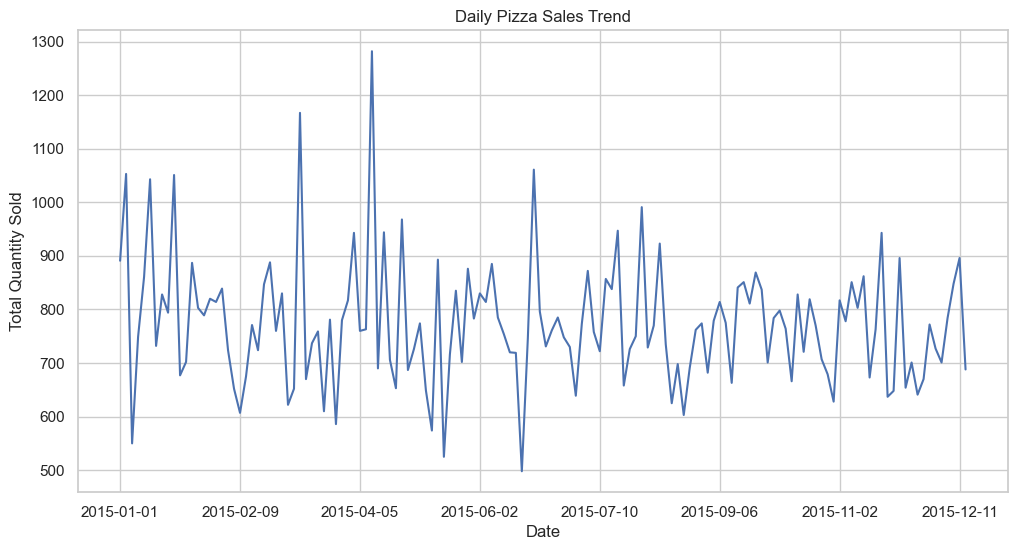

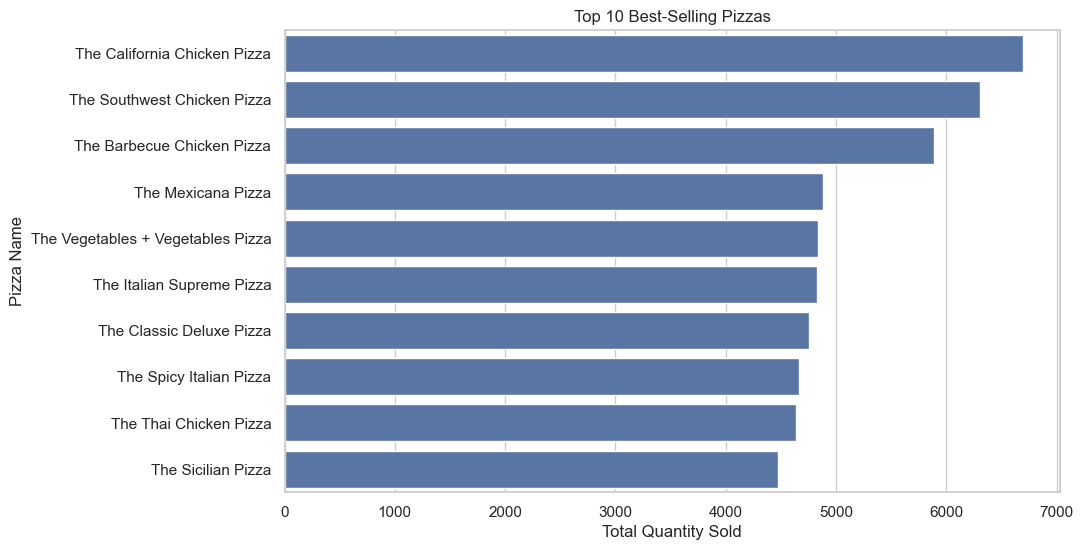

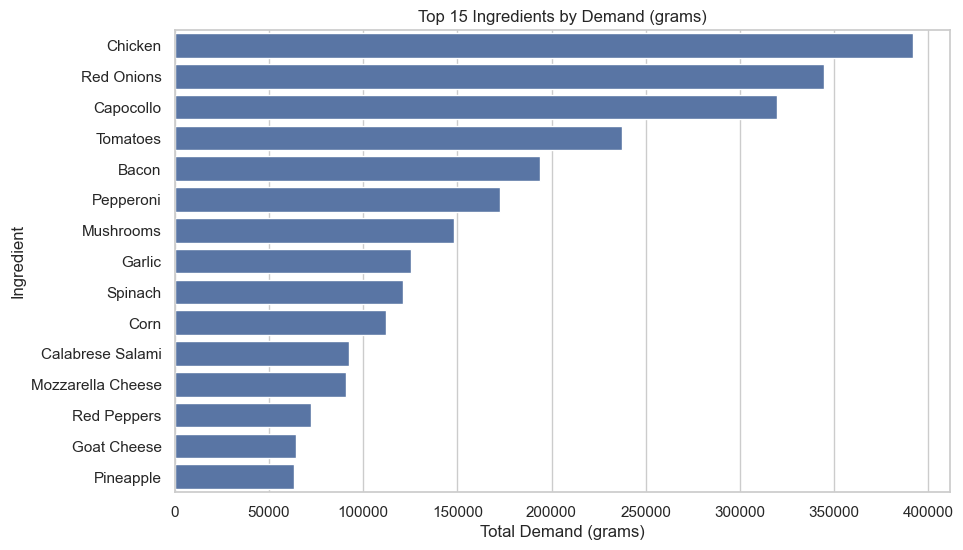

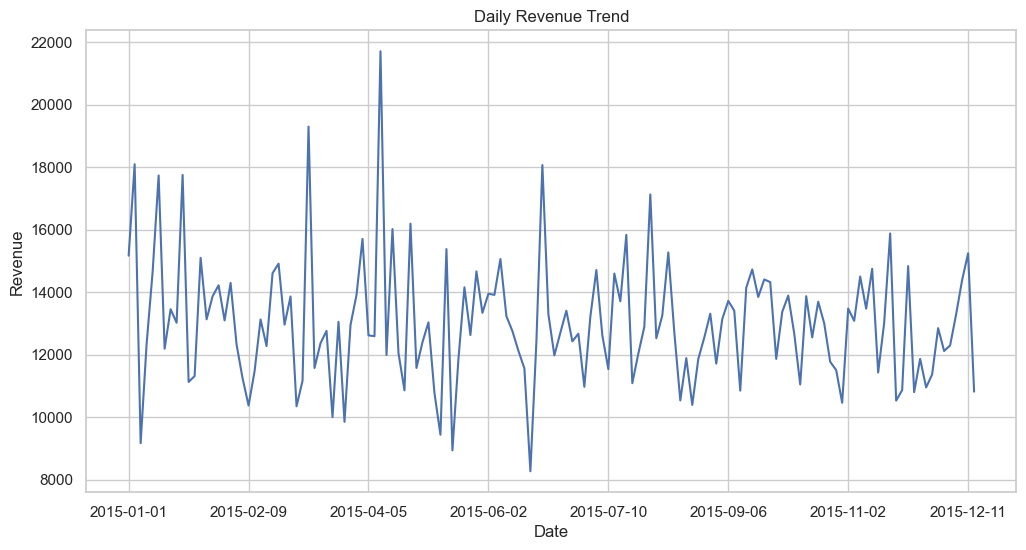

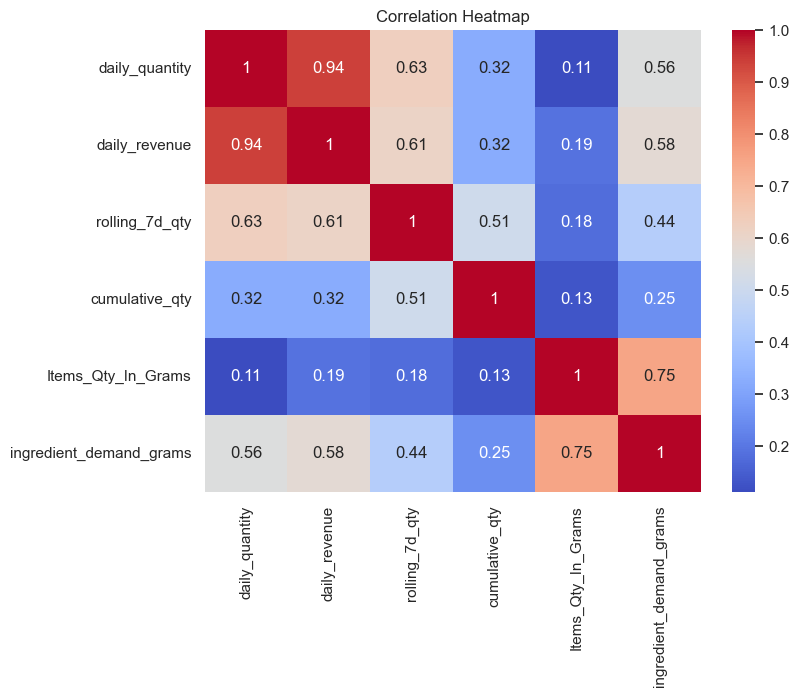

In [18]:
# ----------------------
# 1. IMPORT LIBRARIES
# ----------------------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")

# ----------------------
# 2. LOAD CLEANED DATA
# ----------------------
merged_data = pd.read_csv(
    r"D:\CERTIFICATIONS\GUVI\Capestone Project-5 (Dominos)\Dominos Cleaned and Encoded Dataset\Cleaned_Pizza_Sales.csv"
)

print("✅ Data Loaded")
print("Shape:", merged_data.shape)
print(merged_data.head(5))

# ----------------------
# 3. BASIC DATA CHECKS
# ----------------------
print("\nMissing Values:")
print(merged_data.isnull().sum())

print("\nData Types:")
print(merged_data.dtypes)

print("\nNumeric Summary:")
print(merged_data.describe())

# ----------------------
# 4. SALES TRENDS OVER TIME
# ----------------------
plt.figure(figsize=(12,6))
daily_trend = merged_data.groupby("order_date")["daily_quantity"].sum()
daily_trend.plot()
plt.title("Daily Pizza Sales Trend")
plt.xlabel("Date")
plt.ylabel("Total Quantity Sold")
plt.show()

# ----------------------
# 5. TOP-SELLING PIZZAS
# ----------------------
top_pizzas = (
    merged_data.groupby("pizza_name")["daily_quantity"].sum()
    .sort_values(ascending=False).head(10)
)
plt.figure(figsize=(10,6))
sns.barplot(x=top_pizzas.values, y=top_pizzas.index)
plt.title("Top 10 Best-Selling Pizzas")
plt.xlabel("Total Quantity Sold")
plt.ylabel("Pizza Name")
plt.show()

# ----------------------
# 6. INGREDIENT DEMAND ANALYSIS
# ----------------------
ingredient_demand = (
    merged_data.groupby("pizza_ingredients")["ingredient_demand_grams"].sum()
    .sort_values(ascending=False).head(15)
)
plt.figure(figsize=(10,6))
sns.barplot(x=ingredient_demand.values, y=ingredient_demand.index)
plt.title("Top 15 Ingredients by Demand (grams)")
plt.xlabel("Total Demand (grams)")
plt.ylabel("Ingredient")
plt.show()

# ----------------------
# 7. SALES REVENUE TREND
# ----------------------
plt.figure(figsize=(12,6))
merged_data.groupby("order_date")["daily_revenue"].sum().plot()
plt.title("Daily Revenue Trend")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.show()

# ----------------------
# 8. CORRELATIONS
# ----------------------
plt.figure(figsize=(8,6))
sns.heatmap(merged_data.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()



In [19]:
# ----------------------
# 1. FEATURE ENGINEERING
# ----------------------
merged_data["order_date"] = pd.to_datetime(merged_data["order_date"])

# Time-based features
merged_data["year"] = merged_data["order_date"].dt.year
merged_data["month"] = merged_data["order_date"].dt.month
merged_data["week"] = merged_data["order_date"].dt.isocalendar().week
merged_data["day_of_week"] = merged_data["order_date"].dt.day_name()
merged_data["is_weekend"] = merged_data["day_of_week"].isin(["Saturday", "Sunday"]).astype(int)

# Aggregate daily sales (all pizzas)
daily_sales = (
    merged_data.groupby("order_date")["daily_quantity"].sum().reset_index()
)
daily_sales = daily_sales.rename(columns={"daily_quantity": "total_daily_sales"})

print(daily_sales.head())


  order_date  total_daily_sales
0 2015-01-01                891
1 2015-01-02               1053
2 2015-01-03                550
3 2015-01-04                749
4 2015-01-05                861


MAPE: 10.80%


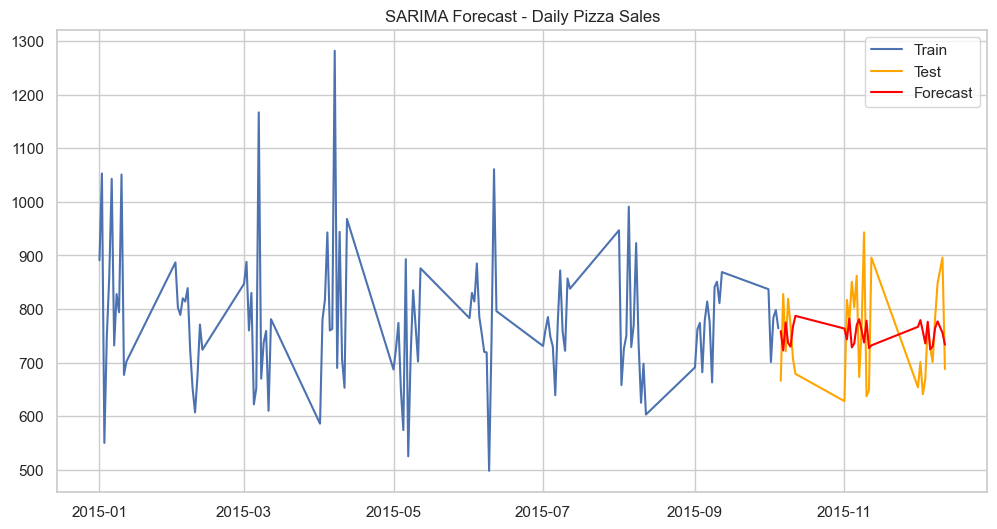

In [21]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np

# Train-test split (e.g., last 30 days for testing)
train = daily_sales.iloc[:-30]
test = daily_sales.iloc[-30:]

# SARIMA model
model = SARIMAX(train["total_daily_sales"], order=(1,1,1), seasonal_order=(1,1,1,7))
sarima_fit = model.fit(disp=False)

# Forecast
forecast = sarima_fit.forecast(steps=30)

# Evaluation
mape = mean_absolute_percentage_error(test["total_daily_sales"], forecast) * 100
print(f"MAPE: {mape:.2f}%")

# Plot
plt.figure(figsize=(12,6))
plt.plot(train["order_date"], train["total_daily_sales"], label="Train")
plt.plot(test["order_date"], test["total_daily_sales"], label="Test", color="orange")
plt.plot(test["order_date"], forecast, label="Forecast", color="red")
plt.legend()
plt.title("SARIMA Forecast - Daily Pizza Sales")
plt.show()


18:31:42 - cmdstanpy - INFO - Chain [1] start processing
18:31:43 - cmdstanpy - INFO - Chain [1] done processing


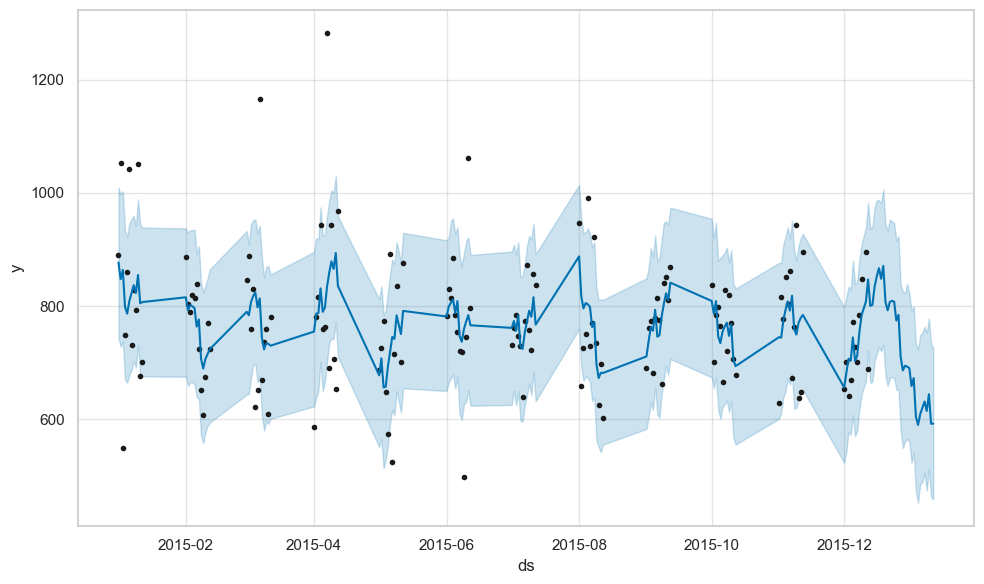

In [22]:
from prophet import Prophet

# Prepare data for Prophet
prophet_data = daily_sales.rename(columns={"order_date": "ds", "total_daily_sales": "y"})

# Initialize and fit model
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
model.fit(prophet_data)

# Forecast next 30 days
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Plot forecast
fig = model.plot(forecast)


### Sales Forecasting Pipeline

In [23]:
# ----------------------
# 1. FEATURE ENGINEERING
# ----------------------
import pandas as pd

# Aggregate to daily sales
daily_sales = merged_data.groupby("order_date")["daily_quantity"].sum().reset_index()
daily_sales["order_date"] = pd.to_datetime(daily_sales["order_date"])
daily_sales = daily_sales.sort_values("order_date")

# Create features
daily_sales["day_of_week"] = daily_sales["order_date"].dt.day_name()
daily_sales["month"] = daily_sales["order_date"].dt.month
daily_sales["is_weekend"] = daily_sales["day_of_week"].isin(["Saturday","Sunday"]).astype(int)

# Rename target for consistency
daily_sales.rename(columns={"daily_quantity": "y"}, inplace=True)

print(daily_sales.head())


  order_date     y day_of_week  month  is_weekend
0 2015-01-01   891    Thursday      1           0
1 2015-01-02  1053      Friday      1           0
2 2015-01-03   550    Saturday      1           1
3 2015-01-04   749      Sunday      1           1
4 2015-01-05   861      Monday      1           0


### SARIMA (Statsmodels)

In [24]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np

# Train-Test Split
train = daily_sales.iloc[:-30]
test = daily_sales.iloc[-30:]

# Fit SARIMA model
sarima_model = SARIMAX(train["y"], order=(2,1,2), seasonal_order=(1,1,1,7))
sarima_result = sarima_model.fit(disp=False)

# Forecast
sarima_forecast = sarima_result.forecast(steps=30)

# Evaluation
mape_sarima = mean_absolute_percentage_error(test["y"], sarima_forecast)
print("SARIMA MAPE:", round(mape_sarima*100, 2), "%")


SARIMA MAPE: 10.76 %


### Prophet (Meta)

### Regression Model (RandomForest)

In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

# Encode day_of_week
daily_sales_ml = daily_sales.copy()
daily_sales_ml = pd.get_dummies(daily_sales_ml, columns=["day_of_week"], drop_first=True)

# Features & Target
X = daily_sales_ml.drop(columns=["order_date","y"])
y = daily_sales_ml["y"]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=30, shuffle=False)

# Train Model
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Forecast
rf_forecast = rf.predict(X_test)

# Evaluation
mape_rf = mean_absolute_percentage_error(y_test, rf_forecast)
print("Random Forest MAPE:", round(mape_rf*100, 2), "%")


Random Forest MAPE: 11.28 %


### Compare Models

In [27]:
print("\n📊 Model Performance (MAPE):")
print("SARIMA:", round(mape_sarima*100, 2), "%")
print("Prophet:", round(mape_prophet*100, 2), "%")
print("Random Forest:", round(mape_rf*100, 2), "%")


📊 Model Performance (MAPE):
SARIMA: 10.76 %
Prophet: 9.75 %
Random Forest: 11.28 %


In [25]:
from prophet import Prophet

# Prophet expects "ds" and "y"
prophet_data = daily_sales[["order_date","y"]].rename(columns={"order_date":"ds"})

# Train/Test Split
prophet_train = prophet_data.iloc[:-30]
prophet_test = prophet_data.iloc[-30:]

# Train model
prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
prophet_model.fit(prophet_train)

# Forecast
future = prophet_model.make_future_dataframe(periods=30)
forecast = prophet_model.predict(future)

# Extract forecast for test period
prophet_forecast = forecast.iloc[-30:]["yhat"]

# Evaluation
mape_prophet = mean_absolute_percentage_error(prophet_test["y"], prophet_forecast)
print("Prophet MAPE:", round(mape_prophet*100, 2), "%")


18:34:45 - cmdstanpy - INFO - Chain [1] start processing
18:34:45 - cmdstanpy - INFO - Chain [1] done processing


Prophet MAPE: 9.75 %


### Prophet Loop

In [28]:
from prophet import Prophet
import pandas as pd

# How many days ahead to forecast
FORECAST_DAYS = 7  

# Ensure order_date is datetime
merged_data["order_date"] = pd.to_datetime(merged_data["order_date"])

# Create empty list to store forecasts
all_forecasts = []

# Loop over each pizza
for pizza_id, group in merged_data.groupby("pizza_name_id"):
    try:
        # Prepare data for Prophet
        df = group.groupby("order_date")["daily_quantity"].sum().reset_index()
        df = df.rename(columns={"order_date": "ds", "daily_quantity": "y"})

        # Skip pizzas with too few data points
        if len(df) < 30:
            continue

        # Train Prophet
        model = Prophet(daily_seasonality=True, yearly_seasonality=True)
        model.fit(df)

        # Make future dataframe
        future = model.make_future_dataframe(periods=FORECAST_DAYS)
        forecast = model.predict(future)

        # Collect results
        forecast_df = forecast[["ds", "yhat"]].tail(FORECAST_DAYS)
        forecast_df["pizza_name_id"] = pizza_id
        forecast_df = forecast_df.rename(columns={"ds": "order_date", "yhat": "forecast_qty"})
        all_forecasts.append(forecast_df)

    except Exception as e:
        print(f"Skipping {pizza_id} due to error: {e}")

# Combine all forecasts
pizza_forecasts = pd.concat(all_forecasts, ignore_index=True)

print("✅ Forecasts generated")
print(pizza_forecasts.head())


18:39:53 - cmdstanpy - INFO - Chain [1] start processing
18:39:53 - cmdstanpy - INFO - Chain [1] done processing
18:39:53 - cmdstanpy - INFO - Chain [1] start processing
18:39:53 - cmdstanpy - INFO - Chain [1] done processing
18:39:53 - cmdstanpy - INFO - Chain [1] start processing
18:39:53 - cmdstanpy - INFO - Chain [1] done processing
18:39:53 - cmdstanpy - INFO - Chain [1] start processing
18:39:53 - cmdstanpy - INFO - Chain [1] done processing
18:39:54 - cmdstanpy - INFO - Chain [1] start processing
18:39:54 - cmdstanpy - INFO - Chain [1] done processing
18:39:54 - cmdstanpy - INFO - Chain [1] start processing
18:39:54 - cmdstanpy - INFO - Chain [1] done processing
18:39:54 - cmdstanpy - INFO - Chain [1] start processing
18:39:54 - cmdstanpy - INFO - Chain [1] done processing
18:39:54 - cmdstanpy - INFO - Chain [1] start processing
18:39:54 - cmdstanpy - INFO - Chain [1] done processing
18:39:55 - cmdstanpy - INFO - Chain [1] start processing
18:39:55 - cmdstanpy - INFO - Chain [1]

✅ Forecasts generated
  order_date  forecast_qty pizza_name_id
0 2015-12-13      2.381312     bbq_ckn_l
1 2015-12-14     -1.735211     bbq_ckn_l
2 2015-12-15     -0.482547     bbq_ckn_l
3 2015-12-16     -0.582428     bbq_ckn_l
4 2015-12-17      2.102769     bbq_ckn_l


### Map to Ingredients

In [29]:
# Merge forecasts with ingredient mapping
forecast_with_ingredients = pizza_forecasts.merge(
    merged_data[["pizza_name_id", "pizza_ingredients", "Items_Qty_In_Grams"]],
    on="pizza_name_id", how="left"
).drop_duplicates()

# Ingredient demand
forecast_with_ingredients["ingredient_demand_grams"] = (
    forecast_with_ingredients["forecast_qty"] * forecast_with_ingredients["Items_Qty_In_Grams"]
)

print(forecast_with_ingredients.head())


  order_date  forecast_qty pizza_name_id  pizza_ingredients  \
0 2015-12-13      2.381312     bbq_ckn_l  Barbecued Chicken   
1 2015-12-13      2.381312     bbq_ckn_l        Red Peppers   
2 2015-12-13      2.381312     bbq_ckn_l      Green Peppers   
3 2015-12-13      2.381312     bbq_ckn_l           Tomatoes   
4 2015-12-13      2.381312     bbq_ckn_l         Red Onions   

   Items_Qty_In_Grams  ingredient_demand_grams  
0                40.0                95.252467  
1                15.0                35.719675  
2                20.0                47.626233  
3                30.0                71.439350  
4                60.0               142.878700  


### Final Purchase Order

In [30]:
purchase_order = (
    forecast_with_ingredients.groupby(["order_date", "pizza_ingredients"])["ingredient_demand_grams"]
    .sum()
    .reset_index()
)

# Convert grams to kg
purchase_order["ingredient_demand_kg"] = purchase_order["ingredient_demand_grams"] / 1000

print("✅ Final Purchase Order (next 7 days):")
print(purchase_order.head(15))


✅ Final Purchase Order (next 7 days):
   order_date    pizza_ingredients  ingredient_demand_grams  \
0  2015-12-07         ?duja Salami               149.528309   
1  2015-12-07  Friggitello Peppers                37.382077   
2  2015-12-07               Garlic                37.382077   
3  2015-12-07             Pancetta               224.292463   
4  2015-12-07           Red Onions               149.528309   
5  2015-12-07             Tomatoes                74.764154   
6  2015-12-08         ?duja Salami               109.919255   
7  2015-12-08  Friggitello Peppers                27.479814   
8  2015-12-08               Garlic                27.479814   
9  2015-12-08             Pancetta               164.878883   
10 2015-12-08           Red Onions               109.919255   
11 2015-12-08             Tomatoes                54.959628   
12 2015-12-09         ?duja Salami               249.437783   
13 2015-12-09     Beef Chuck Roast              3270.378935   
14 2015-12-09    

In [32]:
import pandas as pd

# Assuming forecast_with_ingredients is your DataFrame

# 1️⃣ Clean pizza_ingredients column: remove weird characters
forecast_with_ingredients["pizza_ingredients"] = forecast_with_ingredients["pizza_ingredients"].str.replace(
    r"[^a-zA-Z0-9, ]", "", regex=True
).str.strip()  # remove leading/trailing spaces

# 2️⃣ Aggregate ingredient demand by date and ingredient
purchase_order = (
    forecast_with_ingredients.groupby(["order_date", "pizza_ingredients"])["ingredient_demand_grams"]
    .sum()
    .reset_index()
)

# 3️⃣ Convert grams to kilograms
purchase_order["ingredient_demand_kg"] = (purchase_order["ingredient_demand_grams"] / 1000).round(2)

# 4️⃣ Optional: sort by date and ingredient for readability
purchase_order = purchase_order.sort_values(["order_date", "pizza_ingredients"]).reset_index(drop=True)

# 5️⃣ Display top rows
print("✅ Final Purchase Order (next 7 days):")
print(purchase_order.head(15))

✅ Final Purchase Order (next 7 days):
   order_date    pizza_ingredients  ingredient_demand_grams  \
0  2015-12-07  Friggitello Peppers                37.382077   
1  2015-12-07               Garlic                37.382077   
2  2015-12-07             Pancetta               224.292463   
3  2015-12-07           Red Onions               149.528309   
4  2015-12-07             Tomatoes                74.764154   
5  2015-12-07          duja Salami               149.528309   
6  2015-12-08  Friggitello Peppers                27.479814   
7  2015-12-08               Garlic                27.479814   
8  2015-12-08             Pancetta               164.878883   
9  2015-12-08           Red Onions               109.919255   
10 2015-12-08             Tomatoes                54.959628   
11 2015-12-08          duja Salami               109.919255   
12 2015-12-09     Beef Chuck Roast              3270.378935   
13 2015-12-09          Feta Cheese              1266.929632   
14 2015-12-09    

In [31]:
from prophet import Prophet
import pandas as pd

# =========================
# PARAMETERS
# =========================
FORECAST_DAYS = 7  
OUTPUT_PATH = r"D:\CERTIFICATIONS\GUVI\Capestone Project-5 (Dominos)\Dominos_Forecasts.xlsx"

# =========================
# STEP 1 – Preprocess
# =========================
merged_data["order_date"] = pd.to_datetime(merged_data["order_date"])

all_forecasts = []

# =========================
# STEP 2 – Loop Forecast (Per Pizza)
# =========================
for pizza_id, group in merged_data.groupby("pizza_name_id"):
    try:
        df = group.groupby("order_date")["daily_quantity"].sum().reset_index()
        df = df.rename(columns={"order_date": "ds", "daily_quantity": "y"})

        if len(df) < 30:  # skip pizzas with too little data
            continue

        model = Prophet(daily_seasonality=True, yearly_seasonality=True)
        model.fit(df)

        future = model.make_future_dataframe(periods=FORECAST_DAYS)
        forecast = model.predict(future)

        forecast_df = forecast[["ds", "yhat"]].tail(FORECAST_DAYS)
        forecast_df["pizza_name_id"] = pizza_id
        forecast_df = forecast_df.rename(columns={"ds": "order_date", "yhat": "forecast_qty"})
        all_forecasts.append(forecast_df)

    except Exception as e:
        print(f"Skipping {pizza_id} due to error: {e}")

pizza_forecasts = pd.concat(all_forecasts, ignore_index=True)

# =========================
# STEP 3 – Map to Ingredients
# =========================
ingredient_map = merged_data[["pizza_name_id", "pizza_ingredients", "Items_Qty_In_Grams"]].drop_duplicates()

forecast_with_ingredients = pizza_forecasts.merge(
    ingredient_map, on="pizza_name_id", how="left"
)

forecast_with_ingredients["ingredient_demand_grams"] = (
    forecast_with_ingredients["forecast_qty"] * forecast_with_ingredients["Items_Qty_In_Grams"]
)

# =========================
# STEP 4 – Final Purchase Order
# =========================
purchase_order = (
    forecast_with_ingredients.groupby(["order_date", "pizza_ingredients"])["ingredient_demand_grams"]
    .sum()
    .reset_index()
)

purchase_order["ingredient_demand_kg"] = purchase_order["ingredient_demand_grams"] / 1000

# =========================
# STEP 5 – Export to Excel
# =========================
with pd.ExcelWriter(OUTPUT_PATH, engine="openpyxl") as writer:
    pizza_forecasts.to_excel(writer, sheet_name="Pizza_Forecasts", index=False)
    purchase_order.to_excel(writer, sheet_name="Purchase_Order", index=False)

print(f"✅ Forecasts and Purchase Order saved to {OUTPUT_PATH}")


18:43:08 - cmdstanpy - INFO - Chain [1] start processing
18:43:08 - cmdstanpy - INFO - Chain [1] done processing
18:43:08 - cmdstanpy - INFO - Chain [1] start processing
18:43:08 - cmdstanpy - INFO - Chain [1] done processing
18:43:08 - cmdstanpy - INFO - Chain [1] start processing
18:43:08 - cmdstanpy - INFO - Chain [1] done processing
18:43:08 - cmdstanpy - INFO - Chain [1] start processing
18:43:09 - cmdstanpy - INFO - Chain [1] done processing
18:43:09 - cmdstanpy - INFO - Chain [1] start processing
18:43:09 - cmdstanpy - INFO - Chain [1] done processing
18:43:09 - cmdstanpy - INFO - Chain [1] start processing
18:43:09 - cmdstanpy - INFO - Chain [1] done processing
18:43:09 - cmdstanpy - INFO - Chain [1] start processing
18:43:09 - cmdstanpy - INFO - Chain [1] done processing
18:43:09 - cmdstanpy - INFO - Chain [1] start processing
18:43:09 - cmdstanpy - INFO - Chain [1] done processing
18:43:09 - cmdstanpy - INFO - Chain [1] start processing
18:43:10 - cmdstanpy - INFO - Chain [1]

✅ Forecasts and Purchase Order saved to D:\CERTIFICATIONS\GUVI\Capestone Project-5 (Dominos)\Dominos_Forecasts.xlsx


In [33]:
import pandas as pd
from prophet import Prophet

# =========================
# PARAMETERS
# =========================
FORECAST_DAYS = 7  
OUTPUT_PATH = r"D:\CERTIFICATIONS\GUVI\Capestone Project-5 (Dominos)\Dominos_Forecasts.xlsx"

# =========================
# STEP 0 – Clean Ingredients in Original Data
# =========================
# Remove weird characters from pizza_ingredients
merged_data["pizza_ingredients"] = merged_data["pizza_ingredients"].str.replace(
    r"[^a-zA-Z0-9, ]", "", regex=True
).str.strip()

# =========================
# STEP 1 – Preprocess Dates
# =========================
merged_data["order_date"] = pd.to_datetime(merged_data["order_date"])

all_forecasts = []

# =========================
# STEP 2 – Loop Forecast (Per Pizza)
# =========================
for pizza_id, group in merged_data.groupby("pizza_name_id"):
    try:
        df = group.groupby("order_date")["daily_quantity"].sum().reset_index()
        df = df.rename(columns={"order_date": "ds", "daily_quantity": "y"})

        if len(df) < 30:  # skip pizzas with too little data
            continue

        model = Prophet(daily_seasonality=True, yearly_seasonality=True)
        model.fit(df)

        future = model.make_future_dataframe(periods=FORECAST_DAYS)
        forecast = model.predict(future)

        forecast_df = forecast[["ds", "yhat"]].tail(FORECAST_DAYS)
        forecast_df["pizza_name_id"] = pizza_id
        forecast_df = forecast_df.rename(columns={"ds": "order_date", "yhat": "forecast_qty"})
        all_forecasts.append(forecast_df)

    except Exception as e:
        print(f"Skipping {pizza_id} due to error: {e}")

pizza_forecasts = pd.concat(all_forecasts, ignore_index=True)

# =========================
# STEP 3 – Map to Ingredients
# =========================
ingredient_map = merged_data[["pizza_name_id", "pizza_ingredients", "Items_Qty_In_Grams"]].drop_duplicates()

forecast_with_ingredients = pizza_forecasts.merge(
    ingredient_map, on="pizza_name_id", how="left"
)

# Optional: Split multiple ingredients per pizza into separate rows
forecast_with_ingredients = forecast_with_ingredients.assign(
    pizza_ingredients=forecast_with_ingredients["pizza_ingredients"].str.split(',')
).explode("pizza_ingredients")

# Remove extra spaces again after splitting
forecast_with_ingredients["pizza_ingredients"] = forecast_with_ingredients["pizza_ingredients"].str.strip()

# Calculate ingredient demand in grams
forecast_with_ingredients["ingredient_demand_grams"] = (
    forecast_with_ingredients["forecast_qty"] * forecast_with_ingredients["Items_Qty_In_Grams"]
)

# =========================
# STEP 4 – Final Purchase Order
# =========================
purchase_order = (
    forecast_with_ingredients.groupby(["order_date", "pizza_ingredients"])["ingredient_demand_grams"]
    .sum()
    .reset_index()
)

# Convert grams → kilograms and round
purchase_order["ingredient_demand_kg"] = (purchase_order["ingredient_demand_grams"] / 1000).round(2)

# Sort for readability
purchase_order = purchase_order.sort_values(["order_date", "pizza_ingredients"]).reset_index(drop=True)

# =========================
# STEP 5 – Export to Excel
# =========================
with pd.ExcelWriter(OUTPUT_PATH, engine="openpyxl") as writer:
    pizza_forecasts.to_excel(writer, sheet_name="Pizza_Forecasts", index=False)
    purchase_order.to_excel(writer, sheet_name="Purchase_Order", index=False)

print(f"✅ Forecasts and Purchase Order saved to {OUTPUT_PATH}")


18:50:45 - cmdstanpy - INFO - Chain [1] start processing
18:50:45 - cmdstanpy - INFO - Chain [1] done processing
18:50:45 - cmdstanpy - INFO - Chain [1] start processing
18:50:45 - cmdstanpy - INFO - Chain [1] done processing
18:50:45 - cmdstanpy - INFO - Chain [1] start processing
18:50:45 - cmdstanpy - INFO - Chain [1] done processing
18:50:45 - cmdstanpy - INFO - Chain [1] start processing
18:50:45 - cmdstanpy - INFO - Chain [1] done processing
18:50:45 - cmdstanpy - INFO - Chain [1] start processing
18:50:45 - cmdstanpy - INFO - Chain [1] done processing
18:50:46 - cmdstanpy - INFO - Chain [1] start processing
18:50:46 - cmdstanpy - INFO - Chain [1] done processing
18:50:46 - cmdstanpy - INFO - Chain [1] start processing
18:50:46 - cmdstanpy - INFO - Chain [1] done processing
18:50:46 - cmdstanpy - INFO - Chain [1] start processing
18:50:46 - cmdstanpy - INFO - Chain [1] done processing
18:50:46 - cmdstanpy - INFO - Chain [1] start processing
18:50:46 - cmdstanpy - INFO - Chain [1]

✅ Forecasts and Purchase Order saved to D:\CERTIFICATIONS\GUVI\Capestone Project-5 (Dominos)\Dominos_Forecasts.xlsx


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =========================
# Step 1 – Aggregate actual sales
# =========================
actual_sales = merged_data.groupby("order_date")["daily_quantity"].sum().reset_index()

# =========================
# Step 2 – Convert forecasts to DataFrames
# =========================
def to_dataframe(forecast, name):
    if isinstance(forecast, pd.DataFrame):
        forecast = forecast.copy()
        forecast.columns = ["order_date", name]
        return forecast
    elif isinstance(forecast, pd.Series):
        return pd.DataFrame({
            "order_date": actual_sales["order_date"],
            name: forecast.values
        })
    elif isinstance(forecast, np.ndarray):
        return pd.DataFrame({
            "order_date": actual_sales["order_date"],
            name: forecast
        })
    else:
        raise ValueError(f"Unsupported forecast type: {type(forecast)}")

prophet_forecast = to_dataframe(prophet_forecast['forecast_qty'] if isinstance(prophet_forecast, pd.DataFrame) else prophet_forecast, "Prophet")
sarima_forecast = to_dataframe(sarima_forecast, "SARIMA")
rf_forecast = to_dataframe(rf_forecast, "RandomForest")

# =========================
# Step 3 – Merge all into a single DataFrame
# =========================
comparison = actual_sales.rename(columns={"daily_quantity": "Actual"})
comparison = comparison.merge(prophet_forecast, on="order_date", how="left")
comparison = comparison.merge(sarima_forecast, on="order_date", how="left")
comparison = comparison.merge(rf_forecast, on="order_date", how="left")

# =========================
# Step 4 – Calculate MAPE
# =========================
def mape(actual, forecast):
    actual, forecast = np.array(actual), np.array(forecast)
    return np.mean(np.abs((actual - forecast) / actual)) * 100

prophet_mape = mape(comparison["Actual"], comparison["Prophet"])
sarima_mape = mape(comparison["Actual"], comparison["SARIMA"])
rf_mape = mape(comparison["Actual"], comparison["RandomForest"])

# =========================
# Step 5 – Plot Actual vs Forecasts
# =========================
plt.figure(figsize=(14,6))
plt.plot(comparison['order_date'], comparison['Actual'], label='Actual', color='black', linewidth=2)

for model, color, m in [("Prophet", "blue", prophet_mape),
                        ("SARIMA", "green", sarima_mape),
                        ("RandomForest", "red", rf_mape)]:
    plt.plot(comparison['order_date'], comparison[model], linestyle='--', color=color, label=f"{model} (MAPE: {m:.2f}%)")
    plt.fill_between(comparison['order_date'], comparison['Actual'], comparison[model], color=color, alpha=0.1)

plt.title("Actual vs Forecasted Pizza Sales with MAPE")
plt.xlabel("Date")
plt.ylabel("Quantity Sold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



KeyError: 'forecast_qty'

In [42]:
print(prophet_forecast.head())
print(prophet_forecast.columns)

  order_date    Prophet
0 2015-12-07   7.476415
1 2015-12-08   5.495963
2 2015-12-09  45.465966
3 2015-12-10  95.151121
4 2015-12-11  97.049975
Index(['order_date', 'Prophet'], dtype='object')


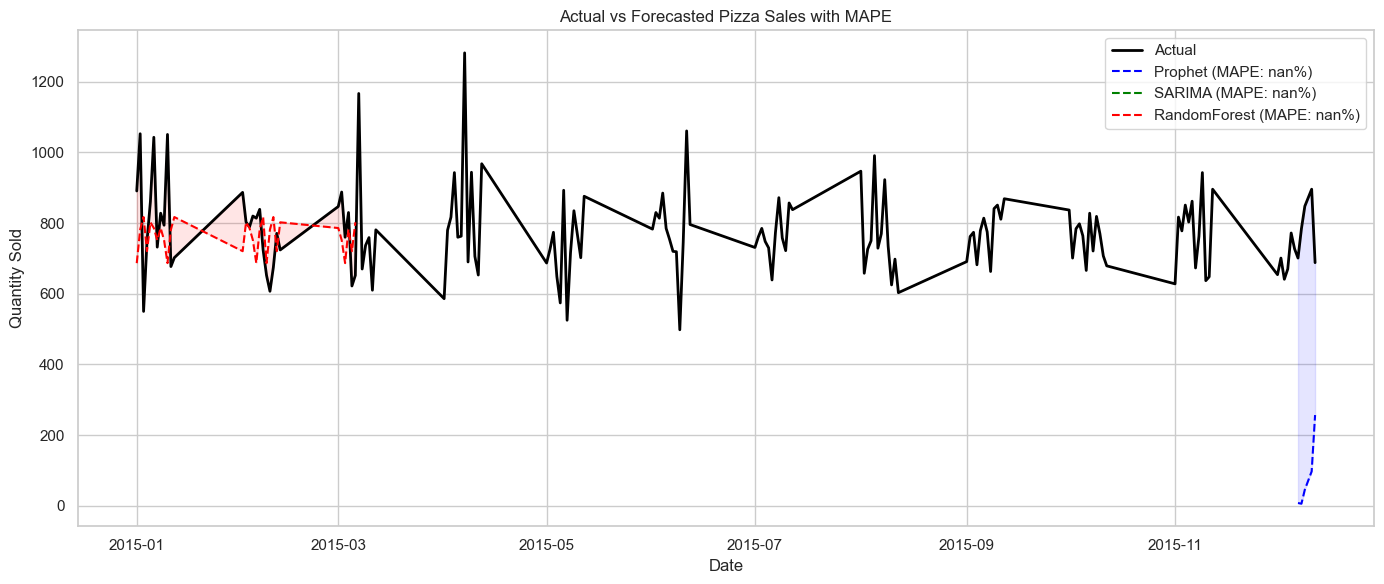

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =========================
# Step 1 – Aggregate actual sales
# =========================
actual_sales = merged_data.groupby("order_date")["daily_quantity"].sum().reset_index()
actual_sales = actual_sales.rename(columns={"daily_quantity": "Actual"})

# =========================
# Step 2 – Function to convert any forecast to DataFrame
# =========================
def forecast_to_df(forecast, name):
    """
    Converts a forecast (DataFrame, Series, or ndarray) into a proper DataFrame with order_date.
    """
    if isinstance(forecast, pd.DataFrame):
        if "order_date" not in forecast.columns:
            forecast = forecast.copy()
            forecast["order_date"] = actual_sales["order_date"].iloc[:len(forecast)]
        forecast = forecast.rename(columns={forecast.columns[1]: name})
        return forecast[["order_date", name]]
    elif isinstance(forecast, (pd.Series, np.ndarray)):
        return pd.DataFrame({
            "order_date": actual_sales["order_date"].iloc[:len(forecast)],
            name: np.array(forecast)
        })
    else:
        raise ValueError(f"Unsupported forecast type: {type(forecast)}")

# Convert all forecasts
# Ensure all order_date columns are datetime
actual_sales["order_date"] = pd.to_datetime(actual_sales["order_date"])
prophet_df["order_date"] = pd.to_datetime(prophet_df["order_date"])
sarima_df["order_date"] = pd.to_datetime(sarima_df["order_date"])
rf_df["order_date"] = pd.to_datetime(rf_df["order_date"])

# Now merge safely
comparison = actual_sales.copy()
for df in [prophet_df, sarima_df, rf_df]:
    comparison = comparison.merge(df, on="order_date", how="left")

# =========================
# Step 3 – Merge all forecasts with actuals
# =========================
comparison = actual_sales.copy()
for df in [prophet_df, sarima_df, rf_df]:
    comparison = comparison.merge(df, on="order_date", how="left")

# =========================
# Step 4 – Calculate MAPE
# =========================
def mape(actual, forecast):
    actual, forecast = np.array(actual), np.array(forecast)
    # Avoid division by zero
    mask = actual != 0
    return np.mean(np.abs((actual[mask] - forecast[mask]) / actual[mask])) * 100

mapes = {}
for model in ["Prophet", "SARIMA", "RandomForest"]:
    mapes[model] = mape(comparison["Actual"], comparison[model])

# =========================
# Step 5 – Plot Actual vs Forecasts with MAPE
# =========================
plt.figure(figsize=(14,6))
plt.plot(comparison['order_date'], comparison['Actual'], label='Actual', color='black', linewidth=2)

colors = {"Prophet": "blue", "SARIMA": "green", "RandomForest": "red"}

for model, color in colors.items():
    plt.plot(comparison['order_date'], comparison[model], linestyle='--', color=color,
             label=f"{model} (MAPE: {mapes[model]:.2f}%)")
    plt.fill_between(comparison['order_date'], comparison['Actual'], comparison[model],
                     color=color, alpha=0.1)

plt.title("Actual vs Forecasted Pizza Sales with MAPE")
plt.xlabel("Date")
plt.ylabel("Quantity Sold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Sales Forecasting

In [52]:
from prophet import Prophet
import pandas as pd

FORECAST_DAYS = 7  # Predict next 7 days

# Prepare data for Prophet
merged_data["order_date"] = pd.to_datetime(merged_data["order_date"])
all_forecasts = []

for pizza_id, group in merged_data.groupby("pizza_name_id"):
    df = group.groupby("order_date")["daily_quantity"].sum().reset_index()
    df = df.rename(columns={"order_date": "ds", "daily_quantity": "y"})
    
    if len(df) < 30:  # Skip pizzas with insufficient history
        continue
    
    model = Prophet(daily_seasonality=True, yearly_seasonality=True)
    model.fit(df)
    
    future = model.make_future_dataframe(periods=FORECAST_DAYS)
    forecast = model.predict(future)
    
    forecast_df = forecast[["ds", "yhat"]].tail(FORECAST_DAYS)
    forecast_df["pizza_name_id"] = pizza_id
    forecast_df = forecast_df.rename(columns={"ds": "order_date", "yhat": "forecast_qty"})
    all_forecasts.append(forecast_df)

pizza_forecasts = pd.concat(all_forecasts, ignore_index=True)


19:12:48 - cmdstanpy - INFO - Chain [1] start processing
19:12:48 - cmdstanpy - INFO - Chain [1] done processing
19:12:48 - cmdstanpy - INFO - Chain [1] start processing
19:12:48 - cmdstanpy - INFO - Chain [1] done processing
19:12:49 - cmdstanpy - INFO - Chain [1] start processing
19:12:49 - cmdstanpy - INFO - Chain [1] done processing
19:12:49 - cmdstanpy - INFO - Chain [1] start processing
19:12:49 - cmdstanpy - INFO - Chain [1] done processing
19:12:49 - cmdstanpy - INFO - Chain [1] start processing
19:12:49 - cmdstanpy - INFO - Chain [1] done processing
19:12:49 - cmdstanpy - INFO - Chain [1] start processing
19:12:49 - cmdstanpy - INFO - Chain [1] done processing
19:12:49 - cmdstanpy - INFO - Chain [1] start processing
19:12:49 - cmdstanpy - INFO - Chain [1] done processing
19:12:50 - cmdstanpy - INFO - Chain [1] start processing
19:12:50 - cmdstanpy - INFO - Chain [1] done processing
19:12:50 - cmdstanpy - INFO - Chain [1] start processing
19:12:50 - cmdstanpy - INFO - Chain [1]

### Ingredient Calculation

In [53]:
ingredient_map = merged_data[["pizza_name_id", "pizza_ingredients", "Items_Qty_In_Grams"]].drop_duplicates()

forecast_with_ingredients = pizza_forecasts.merge(
    ingredient_map, on="pizza_name_id", how="left"
)

# Calculate total ingredient demand in grams
forecast_with_ingredients["ingredient_demand_grams"] = (
    forecast_with_ingredients["forecast_qty"] * forecast_with_ingredients["Items_Qty_In_Grams"]
)


### Purchase Order Creation


In [54]:
purchase_order = (
    forecast_with_ingredients.groupby(["order_date", "pizza_ingredients"])["ingredient_demand_grams"]
    .sum()
    .reset_index()
)

# Convert grams to kilograms
purchase_order["ingredient_demand_kg"] = purchase_order["ingredient_demand_grams"] / 1000

# Optional: Sort by ingredient for clarity
purchase_order = purchase_order.sort_values(["pizza_ingredients", "order_date"])


### Save Results

In [55]:
OUTPUT_PATH = r"D:\CERTIFICATIONS\GUVI\Capestone Project-5 (Dominos)\Dominos_Forecasts.xlsx"

with pd.ExcelWriter(OUTPUT_PATH, engine="openpyxl") as writer:
    pizza_forecasts.to_excel(writer, sheet_name="Pizza_Forecasts", index=False)
    purchase_order.to_excel(writer, sheet_name="Purchase_Order", index=False)

print(f"✅ Forecasts and Purchase Order saved to {OUTPUT_PATH}")


✅ Forecasts and Purchase Order saved to D:\CERTIFICATIONS\GUVI\Capestone Project-5 (Dominos)\Dominos_Forecasts.xlsx


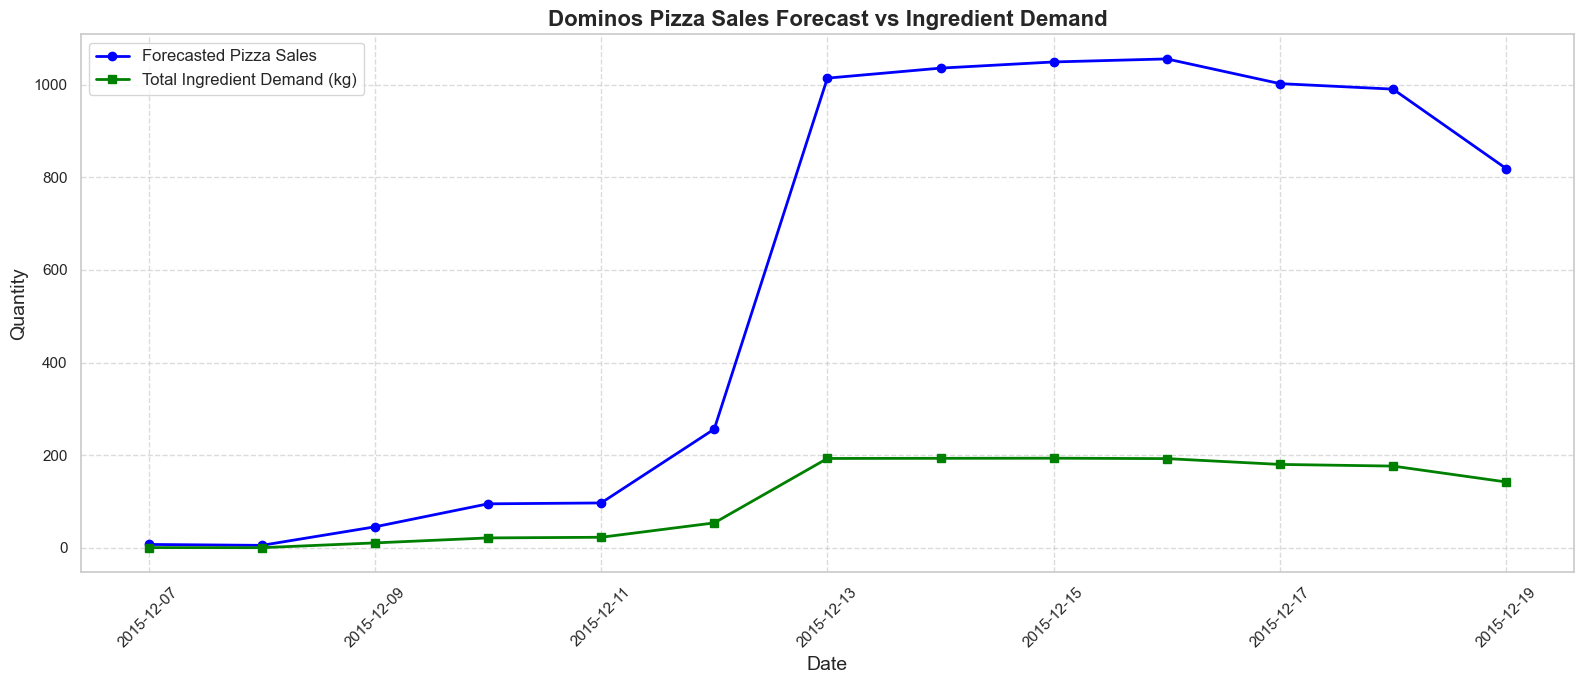

C:\Users\BERLIN SAMUEL RAJ\AppData\Local\Temp\ipykernel_9580\629790354.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_ingredients.values, y=top_ingredients.index, palette="viridis")


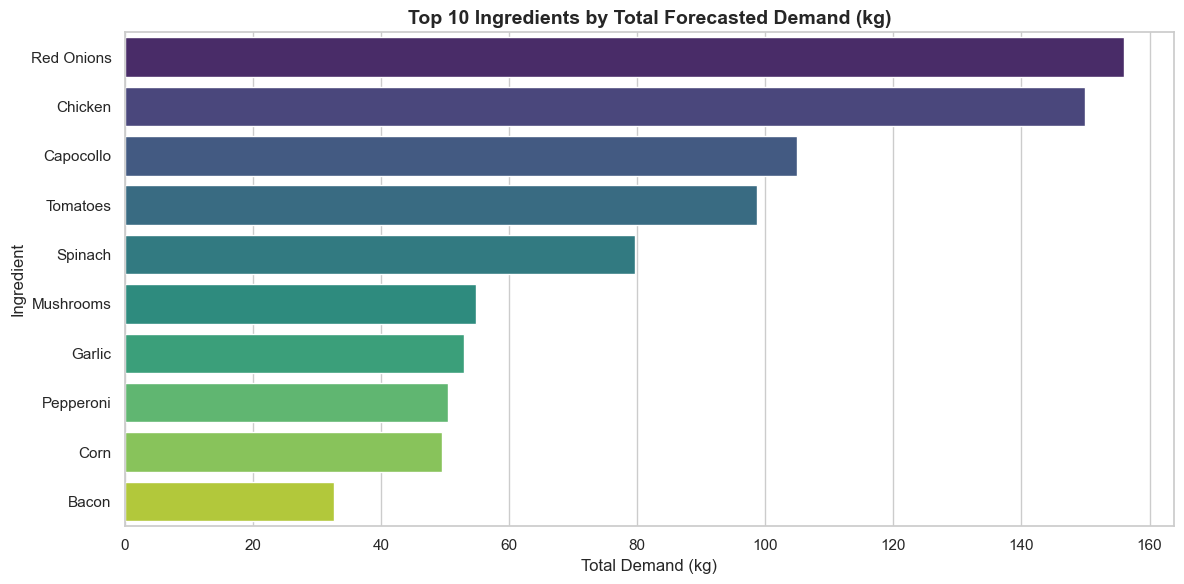

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# =========================
# Step 1 – Aggregate total forecasted pizza sales per day
# =========================
daily_sales_forecast = pizza_forecasts.groupby("order_date")["forecast_qty"].sum().reset_index()
daily_sales_forecast = daily_sales_forecast.rename(columns={"forecast_qty": "Forecasted_Sales"})

# =========================
# Step 2 – Aggregate total ingredient demand per day
# =========================
# Ensure ingredient_demand_kg exists
forecast_with_ingredients["ingredient_demand_kg"] = forecast_with_ingredients["ingredient_demand_grams"] / 1000

# Now aggregate
daily_ingredient_demand = forecast_with_ingredients.groupby("order_date")["ingredient_demand_kg"].sum().reset_index()
# =========================
# Step 3 – Plot Forecast vs Ingredients
# =========================
sns.set(style="whitegrid")
plt.figure(figsize=(16,7))

# Forecasted pizza sales line
plt.plot(daily_sales_forecast["order_date"], daily_sales_forecast["Forecasted_Sales"],
         marker='o', color='blue', label="Forecasted Pizza Sales", linewidth=2)

# Ingredient demand line
plt.plot(daily_ingredient_demand["order_date"], daily_ingredient_demand["ingredient_demand_kg"],
         marker='s', color='green', label="Total Ingredient Demand (kg)", linewidth=2)

# Labels, title, legend
plt.title("Dominos Pizza Sales Forecast vs Ingredient Demand", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=14)
plt.ylabel("Quantity", fontsize=14)
plt.xticks(rotation=45)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# =========================
# Step 4 – Optional: Top ingredients by total demand
# =========================
top_ingredients = forecast_with_ingredients.groupby("pizza_ingredients")["ingredient_demand_kg"].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(x=top_ingredients.values, y=top_ingredients.index, palette="viridis")
plt.title("Top 10 Ingredients by Total Forecasted Demand (kg)", fontsize=14, fontweight='bold')
plt.xlabel("Total Demand (kg)", fontsize=12)
plt.ylabel("Ingredient", fontsize=12)
plt.tight_layout()
plt.show()


In [49]:
print(actual_sales['order_date'].dtype)
print(prophet_forecast['order_date'].dtype)

datetime64[ns]
datetime64[ns]


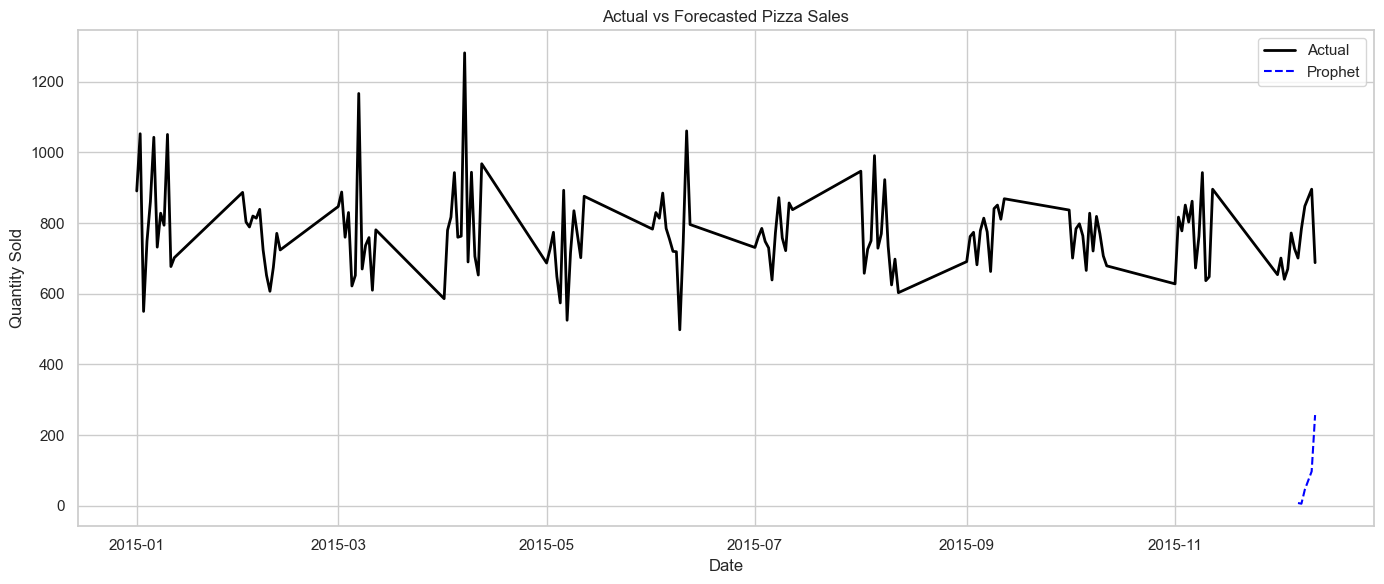

In [35]:
import matplotlib.pyplot as plt
import pandas as pd

# =========================
# Step 1 – Prepare Actual Sales
# =========================
# Aggregate total daily sales across all pizzas
actual_sales = merged_data.groupby("order_date")["daily_quantity"].sum().reset_index()

# =========================
# Step 2 – Prepare Forecasts
# =========================
# Use your Prophet forecasts (already calculated in pizza_forecasts)
prophet_forecast = pizza_forecasts.groupby("order_date")["forecast_qty"].sum().reset_index()

# Optional: placeholders if you have SARIMA and Random Forest forecasts
# Replace sarima_forecast_df and rf_forecast_df with your actual forecast DataFrames
# sarima_forecast = sarima_forecast_df.groupby("order_date")["forecast_qty"].sum().reset_index()
# rf_forecast = rf_forecast_df.groupby("order_date")["forecast_qty"].sum().reset_index()

# =========================
# Step 3 – Merge DataFrames for Plotting
# =========================
comparison = actual_sales.rename(columns={"daily_quantity": "Actual"})
comparison = comparison.merge(prophet_forecast.rename(columns={"forecast_qty": "Prophet"}), on="order_date", how="left")

# If SARIMA and Random Forest forecasts exist, merge them too
# comparison = comparison.merge(sarima_forecast.rename(columns={"forecast_qty": "SARIMA"}), on="order_date", how="left")
# comparison = comparison.merge(rf_forecast.rename(columns={"forecast_qty": "RandomForest"}), on="order_date", how="left")

# =========================
# Step 4 – Plot
# =========================
plt.figure(figsize=(14,6))
plt.plot(comparison['order_date'], comparison['Actual'], label='Actual', color='black', linewidth=2)
plt.plot(comparison['order_date'], comparison['Prophet'], label='Prophet', linestyle='--', color='blue')

# Uncomment if SARIMA and Random Forest are available
# plt.plot(comparison['order_date'], comparison['SARIMA'], label='SARIMA', linestyle='--', color='green')
# plt.plot(comparison['order_date'], comparison['RandomForest'], label='Random Forest', linestyle='--', color='red')

plt.title("Actual vs Forecasted Pizza Sales")
plt.xlabel("Date")
plt.ylabel("Quantity Sold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


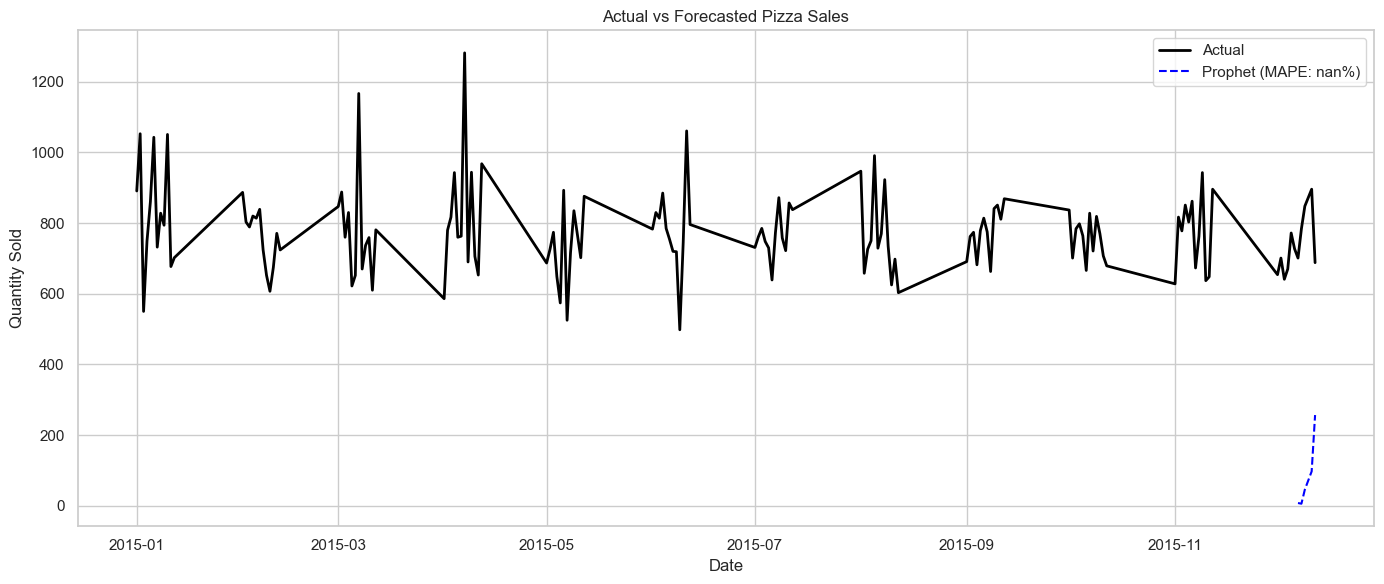

In [36]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# =========================
# Step 1 – Prepare Actual Sales
# =========================
actual_sales = merged_data.groupby("order_date")["daily_quantity"].sum().reset_index()

# =========================
# Step 2 – Prepare Forecasts
# =========================
prophet_forecast = pizza_forecasts.groupby("order_date")["forecast_qty"].sum().reset_index()

# Optional placeholders for SARIMA and Random Forest
# sarima_forecast = sarima_forecast_df.groupby("order_date")["forecast_qty"].sum().reset_index()
# rf_forecast = rf_forecast_df.groupby("order_date")["forecast_qty"].sum().reset_index()

# =========================
# Step 3 – Merge DataFrames
# =========================
comparison = actual_sales.rename(columns={"daily_quantity": "Actual"})
comparison = comparison.merge(prophet_forecast.rename(columns={"forecast_qty": "Prophet"}), on="order_date", how="left")

# Uncomment if SARIMA and RF exist
# comparison = comparison.merge(sarima_forecast.rename(columns={"forecast_qty": "SARIMA"}), on="order_date", how="left")
# comparison = comparison.merge(rf_forecast.rename(columns={"forecast_qty": "RandomForest"}), on="order_date", how="left")

# =========================
# Step 4 – Calculate MAPE
# =========================
def calculate_mape(actual, forecast):
    actual, forecast = np.array(actual), np.array(forecast)
    return np.mean(np.abs((actual - forecast) / actual)) * 100

prophet_mape = calculate_mape(comparison["Actual"], comparison["Prophet"])
# sarima_mape = calculate_mape(comparison["Actual"], comparison["SARIMA"])
# rf_mape = calculate_mape(comparison["Actual"], comparison["RandomForest"])

# =========================
# Step 5 – Plot with MAPE
# =========================
plt.figure(figsize=(14,6))
plt.plot(comparison['order_date'], comparison['Actual'], label='Actual', color='black', linewidth=2)
plt.plot(comparison['order_date'], comparison['Prophet'], label=f'Prophet (MAPE: {prophet_mape:.2f}%)', linestyle='--', color='blue')

# Uncomment if SARIMA and RF exist
# plt.plot(comparison['order_date'], comparison['SARIMA'], label=f'SARIMA (MAPE: {sarima_mape:.2f}%)', linestyle='--', color='green')
# plt.plot(comparison['order_date'], comparison['RandomForest'], label=f'Random Forest (MAPE: {rf_mape:.2f}%)', linestyle='--', color='red')

plt.title("Actual vs Forecasted Pizza Sales")
plt.xlabel("Date")
plt.ylabel("Quantity Sold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [17]:
print("Columns in dataset:")
print(merged_data.columns.tolist())

Columns in dataset:
['order_date', 'pizza_name_id', 'daily_quantity', 'daily_revenue', 'rolling_7d_qty', 'cumulative_qty', 'pizza_name', 'pizza_ingredients', 'Items_Qty_In_Grams', 'ingredient_demand_grams']
